# Сборный проект

По легенде, мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.

Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

План будет следующий:
1. Получение и предобработка данных
2. Проверка данных
3. Построение воронки событий
4. Изучение результата эксперимента
5. Общий вывод

## Получение и предобработка данных

In [1]:
import pandas as pd
from datetime import datetime
import math as mth
from scipy import stats as st
import numpy as np

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


Не нравятся названия столбцов, так как они не совсем интуитивно понятны и написаны не по правилам змеиного регистра. Переименуем в более понятные и удобные названия

In [4]:
df = df.rename(columns = {
    'EventName': 'event_name', 'DeviceIDHash' : 'user_id', 'EventTimestamp' : 'datetime', 'ExpId' : 'group'})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   datetime    244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков нет, но некоторые данные можно изменить ('datetime' перевести в datetime) и добавить новый столбец с датой

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')

In [7]:
df['date'] = df['datetime'].dt.floor('D') #округляем время до дня

In [8]:
df.duplicated().sum() #Количество явных дубликатов в датафрейме

413

In [9]:
df[df.duplicated(keep=False)]

,event_name,user_id,datetime,group,date
452,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30
2348,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31
3572,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01
...,...,...,...,...,...
242359,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07
242634,MainScreenAppear,4097782667445790512,2019-08-07 19:36:58,246,2019-08-07


Увидели, что есть дубликаты, проверили глазами, что совпадают строки полностью, 768 строк дубликатов, из них 413 - дубликаты. Так избавимся же от них!

In [10]:
df = df.drop_duplicates().reset_index()

In [11]:
(df.groupby('user_id')['group'].nunique() >= 2).sum() #Проверяем, есть ли кто-то в нескольких группах

0

**Вывод:**Получили данные, предобработали, поменяли названия столбцов(и добавили новые), проверили на явные дубликаты(и убрали их), проверили, не находится ли кто-либо из пользователей в нескольких группах(никого нет). Видим, что у нас 2 контрольные (246 и 247) и 1 экспериментальная(тестовая, получается) группа(248)

## Проверка данных

Здесь мы будем смотреть на данные и делать срезы по различным условиям, отсеивая аномальные результаты

Сначала узнаем, сколько у нас уникальных пользователей и событий и сколько в среднем приходится на 1 пользователя событий

In [12]:
print('Уникальных событий в логе -', df['event_name'].nunique())
print('Уникальных пользоватей в логе -', df['user_id'].nunique())

Уникальных событий в логе - 5
Уникальных пользоватей в логе - 7551


In [13]:
uniq_cnt_before = df.groupby('event_name')['user_id'].nunique().reset_index()
count_cnt_before = df.groupby('event_name')['user_id'].count().reset_index()
table = uniq_cnt_before.merge(count_cnt_before, on = 'event_name')
table = table.rename(columns = {'user_id_x': 'unique', 'user_id_y': 'count'})
table['mean'] = round(table['count'] / table['unique'], 2)
table.sort_values(by='count', ascending=False) 

,event_name,unique,count,mean
1,MainScreenAppear,7439,119101,16.01
2,OffersScreenAppear,4613,46808,10.15
0,CartScreenAppear,3749,42668,11.38
3,PaymentScreenSuccessful,3547,34118,9.62
4,Tutorial,847,1018,1.20


Теперь проверим, данными за какой период мы располагаем:

In [14]:
display(df['datetime'].min())
df['datetime'].max()

Timestamp('2019-07-25 04:43:36')

Timestamp('2019-08-07 21:15:17')

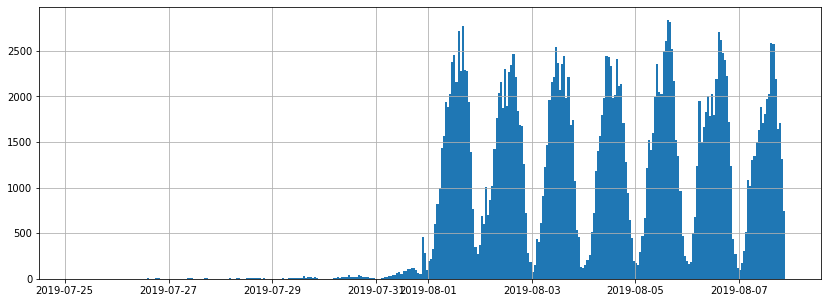

In [16]:
# код ревьюера
df['datetime'].hist(bins=14*24, figsize=(14, 5));

Видим, что первое время количество событий минимально. Несмотря на то, что технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого(это может «перекашивать данные»), мы отсеем часть. Я посмотрел, подумал и решил, что мы возьмем данные с 2019-08-01, но сначала проверим, что не отсеем слишком большое количество начений:

In [17]:
df[df['datetime'] <= datetime(2019, 7, 31)]['date'].count()

796

In [18]:
df = df.query('date > "2019-07-31"') #Нас утраивает такое количество убранных значений, поэтому удаляем их

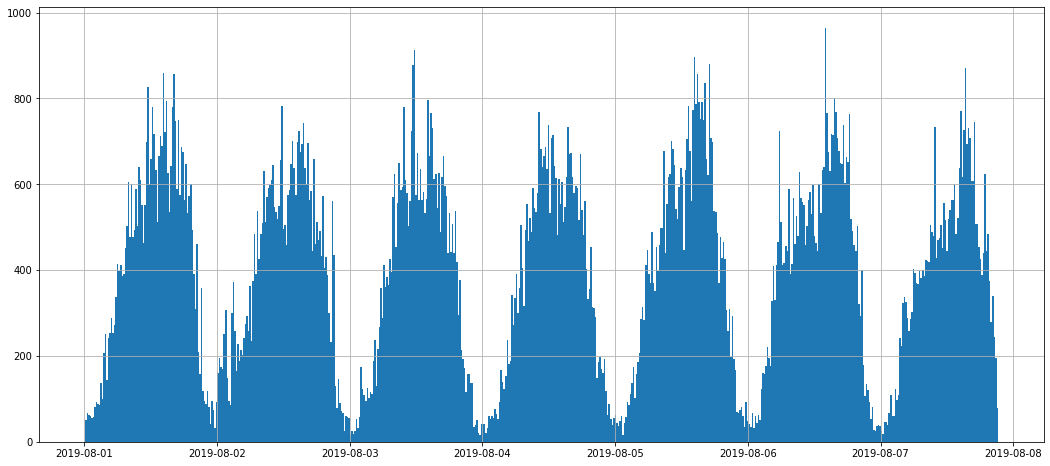

In [19]:
df['datetime'].hist(figsize=(18,8), bins = 30*20);

Видим, что значения распределены равномерно

In [20]:
df.info() #убрали 4 тысячи строчек, это 1.3 %, нас это устраивает

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   index       240887 non-null  int64         
 1   event_name  240887 non-null  object        
 2   user_id     240887 non-null  int64         
 3   datetime    240887 non-null  datetime64[ns]
 4   group       240887 non-null  int64         
 5   date        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.9+ MB


In [21]:
uniq_cnt_after = df.groupby('event_name')['user_id'].nunique().reset_index()
count_cnt_after = df.groupby('event_name')['user_id'].count().reset_index()
table = uniq_cnt_after.merge(count_cnt_after, on = 'event_name')
table = table.rename(columns = {'user_id_x': 'unique', 'user_id_y': 'count'})
table['mean'] = round(table['count'] / table['unique'], 2)
table.sort_values(by='count', ascending=False) 

,event_name,unique,count,mean
1,MainScreenAppear,7419,117328,15.81
2,OffersScreenAppear,4593,46333,10.09
0,CartScreenAppear,3734,42303,11.33
3,PaymentScreenSuccessful,3539,33918,9.58
4,Tutorial,840,1005,1.20


In [22]:
#Потери в количестве уникальных пользователей
display(uniq_cnt_after['user_id'].sort_values(ascending=False) / uniq_cnt_before['user_id'].sort_values(ascending=False))
uniq_cnt_before['user_id'].sort_values(ascending=False) - uniq_cnt_after['user_id'].sort_values(ascending=False)

1    0.997311
2    0.995664
0    0.995999
3    0.997745
4    0.991736
Name: user_id, dtype: float64

1    20
2    20
0    15
3     8
4     7
Name: user_id, dtype: int64

In [23]:
#Потери в количестве событий
display(count_cnt_after['user_id'].sort_values(ascending=False) / count_cnt_before['user_id'].sort_values(ascending=False))
count_cnt_before['user_id'].sort_values(ascending=False) - count_cnt_after['user_id'].sort_values(ascending=False)

1    0.985113
2    0.989852
0    0.991446
3    0.994138
4    0.987230
Name: user_id, dtype: float64

1    1773
2     475
0     365
3     200
4      13
Name: user_id, dtype: int64

In [24]:
print('Уникальных событий в логе -', df['event_name'].nunique())
print('Уникальных пользоватей в логе -', df['user_id'].nunique())

Уникальных событий в логе - 5
Уникальных пользоватей в логе - 7534


In [25]:
display(df['group'].unique())                               #Смотрим, остались ли все 3 группы
display(df[df['group'] == 246]['user_id'].count())          #И проверяем их количество, группы +- равны
display(df[df['group'] == 247]['user_id'].count())
display(df[df['group'] == 248]['user_id'].count())

array([246, 247, 248])

79302

77022

84563

**Вывод:**Узнали, что у нас 5 уникальных событий и 7534 пользователя в конечном датафрейме. В процессе предобработки данных убрали 3239 строчек (1.3% от первичных данных) и 17 пользователей (0.2 %). Помимо этого, изменили диапазон времени, который будем исследовать, так как первое время было малое количество событий и было решено их отбросить

## Воронка событий

Здесь мы посмотрим, какие события наиболее и наименее популярны(да и что это за события, в принципе), какой процент пользователей теряется на каждом этапе и отбросим этап, который посещают слишком маленькое количество пользователей (если это не оплата, конечно))

In [26]:
df.groupby('event_name')['user_id'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: user_id, dtype: int64

Видим список событий и их "популярность". Наиболее частое событие - MainScreenAppear - появление главного экрана, на 2 месте - OffersScreenAppear - появление предложений на экране, на 3 - CartScreenAppear - появление экрана корзины, на 4 - PaymentScreenSuccessful - появление экрана успешной оплаты, а на 5 месте находится Tutorial - обучение, которое посещают аномально низкое количество раз. 

Соответственно, делаем вывод, что последовательность действий пользователя такова: пользователь заходит в приложение, видит главный экран, появляются предложения, он добавляет это в корзину и оплачивает

In [27]:
display(df.groupby('event_name').agg({'user_id' : 'nunique'}).sort_values(by='user_id', ascending=False))
round(df['user_id'].nunique() / df.groupby('event_name').agg({'user_id' : 'nunique'}).sum() * 100, 2)

,user_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


user_id    37.44
dtype: float64

Здесь то же самое, что и выше, но здесь мы смотрим по уникальными пользователям 

Стоит заметить, что процент пользователей, совершивших действие, равен 37.44%

In [28]:
round(
    100 * df.groupby('event_name').agg({'user_id': 'nunique'}) / df['user_id'].nunique(), 2
).sort_values(by='user_id', ascending=False)

,user_id
event_name,
MainScreenAppear,98.47
OffersScreenAppear,60.96
CartScreenAppear,49.56
PaymentScreenSuccessful,46.97
Tutorial,11.15


В принципе, то же самое, но в процентах(считаем от числа пользователей, совершивших действие)

In [29]:
df = df.query('event_name != "Tutorial"') #Исключаем обучение из списка

In [30]:
names = df['event_name'].unique()
names

array(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful'], dtype=object)

In [31]:
for i in range(1, len(names)):
    print('Процент людей, перешедших от', names[i], 'до', names[i-1])
    print(round(100 *df[df['event_name'] == names[i]]['user_id'].nunique()
          / df[df['event_name'] == names[i-1]]['user_id'].nunique(), 2))

Процент людей, перешедших от OffersScreenAppear до MainScreenAppear
61.91
Процент людей, перешедших от CartScreenAppear до OffersScreenAppear
81.3
Процент людей, перешедших от PaymentScreenSuccessful до CartScreenAppear
94.78


**Вывод:** Построили воронку событий, выглядит она так:
1.MainScreenAppear - появление главного экрана
2. OffersScreenAppear - появление предложений на экране
3. CartScreenAppear - появление экрана корзины
4. PaymentScreenSuccessful - появление экрана успешной оплаты

Там еще было обучение, но оно на то и "было"...

Узнали, что только 37.44% пользователей доходит до совершения любого события, что как-то неправильно и мало Наиболее большие потери пользователей происходят при переходе с главного экрана на экран предложений (38.19%)

## Изучение результата эксперимента

Тут мы смотрим, сколько у нас пользователей в группах(да, еще раз, на всякий случай), задаем различные функции для расчета переменных, изучаем, есть ли статистические отличия между группами, смотрим на различия в выводах при различных уровнях статистической значимости и делаем соответствующие выводы

In [32]:
display(df[df['group'] == 246]['user_id'].count())          
display(df[df['group'] == 247]['user_id'].count())
display(df[df['group'] == 248]['user_id'].count())

78985

76684

84213

In [33]:
def event_stats(event):
    t1 = df[df['event_name'] == event]
    t2 = t1.groupby('group').agg({'user_id': 'nunique'})
    t3 = df.groupby('group').agg({'user_id': 'nunique'})
    t2.columns = ['event']
    t3.columns = ['group']
    t3= t2.join(t3)
    
    t3.loc['246-247', 'event'] = t3.loc[246, 'event'] + t3.loc[247, 'event']
    t3.loc['246-247', 'group'] = t3.loc[246, 'group'] + t3.loc[247, 'group']
    
    t3['percent'] = (t3['event'] / t3['group']).map(lambda x: '{0:.2%}'.format(x))
    
    return t3

Функция для объединения данных по группам в 1 табличку. Будем ее использовать для того, чтобы смотреть на данные по пользователям в разрезе событий. Здесь столбец 'event' отвечает за количество людей, перешедших на этот этап воронки, 'group' - общее количество людей в группе, 'percent' - отношение людей, перешедших на этап воронки, к количеству людей в группе

In [34]:
def z_test(new, previous):
    p1 = new[0] / previous[0]
    p2 = new[1] / previous[1]
    difference = p1 - p2
    p_combined = (new[0] + new[1]) / (previous[0] + previous[1])
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / previous[0] + 1 / previous[1]))
    distr = st.norm(0, 1)
    p_value = round((1 - distr.cdf(abs(z_value))) * 2, 3) 
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Функция для сравнения долей с помощью z-теста. С его помощью мы проверим, есть ли разница в долях или нет. Уровень значимости зададим в другой функции, так запланировано

In [35]:
for i in names:
    display(i)
    display(event_stats(i))

'MainScreenAppear'

,event,group,percent
group,,,
246,2450.0,2483.0,98.67%
247,2476.0,2512.0,98.57%
248,2493.0,2535.0,98.34%
246-247,4926.0,4995.0,98.62%


'OffersScreenAppear'

,event,group,percent
group,,,
246,1542.0,2483.0,62.10%
247,1520.0,2512.0,60.51%
248,1531.0,2535.0,60.39%
246-247,3062.0,4995.0,61.30%


'CartScreenAppear'

,event,group,percent
group,,,
246,1266.0,2483.0,50.99%
247,1238.0,2512.0,49.28%
248,1230.0,2535.0,48.52%
246-247,2504.0,4995.0,50.13%


'PaymentScreenSuccessful'

,event,group,percent
group,,,
246,1200.0,2483.0,48.33%
247,1158.0,2512.0,46.10%
248,1181.0,2535.0,46.59%
246-247,2358.0,4995.0,47.21%


Здесь требуется предисловие. Написал я, значит, функции, вывел данные, все красиво. А как прописать, чтобы сами данные подтягивались - не придумал, хотя думал несколько дней. Таким образом получилось самокритичное название функции (в следующий раз поменяю, но надеюсь на подсказку, как это оптимизировать и не вбивать ручками). 

Теперь коротко о сути: при помощи z-теста мы будем искать различия в долях. Будем сравнивать 248 группу со всеми и 247 с 246(чтобы понять, отличаются ли наши контрольные группы). Уровень стат значимости тоже будем задавать в функции, так как будем проверять, насколько изменятся результаты при разлиных уровнях значимости.

Да, даже это я обернул в простейшую функцию, а как по-человечески взять значения - не придумал)

In [36]:
def stats(alph):
    global alpha    #Здесь мы объявляем alpha глобальной, чтобы в z-тесте она менялась
    alpha = alph    #Но нельзя, чтобы название переменной в функции было и глобальным, поэтому проявили чудеса смекалки
    print('Проверка 247 и 246 группы при критическом уровне статистической значимости alpha =', alpha)
    z_test(np.array([event_stats('MainScreenAppear')['event'][247], 
                     event_stats('MainScreenAppear')['event'][246]]), 
           np.array([event_stats('MainScreenAppear')['group'][247], 
                     event_stats('MainScreenAppear')['group'][246]]))
    z_test(np.array([event_stats('OffersScreenAppear')['event'][247], 
                     event_stats('OffersScreenAppear')['event'][246]]), 
           np.array([event_stats('OffersScreenAppear')['group'][247], 
                     event_stats('OffersScreenAppear')['group'][246]]))
    z_test(np.array([event_stats('CartScreenAppear')['event'][247], 
                     event_stats('CartScreenAppear')['event'][246]]), 
           np.array([event_stats('CartScreenAppear')['group'][247], 
                     event_stats('CartScreenAppear')['group'][246]]))
    z_test(np.array([event_stats('PaymentScreenSuccessful')['event'][247], 
                     event_stats('PaymentScreenSuccessful')['event'][246]]), 
           np.array([event_stats('PaymentScreenSuccessful')['group'][247], 
                     event_stats('PaymentScreenSuccessful')['group'][246]]))
    print()
    print('Проверка 248 и 246 группы при критическом уровне статистической значимости alpha =', alpha)
    z_test(np.array([event_stats('MainScreenAppear')['event'][248], 
                     event_stats('MainScreenAppear')['event'][246]]), 
           np.array([event_stats('MainScreenAppear')['group'][248], 
                     event_stats('MainScreenAppear')['group'][246]]))
    z_test(np.array([event_stats('OffersScreenAppear')['event'][248], 
                     event_stats('OffersScreenAppear')['event'][246]]), 
           np.array([event_stats('OffersScreenAppear')['group'][248], 
                     event_stats('OffersScreenAppear')['group'][246]]))
    z_test(np.array([event_stats('CartScreenAppear')['event'][248], 
                     event_stats('CartScreenAppear')['event'][246]]), 
           np.array([event_stats('CartScreenAppear')['group'][248], 
                     event_stats('CartScreenAppear')['group'][246]]))
    z_test(np.array([event_stats('PaymentScreenSuccessful')['event'][248], 
                     event_stats('PaymentScreenSuccessful')['event'][246]]), 
           np.array([event_stats('PaymentScreenSuccessful')['group'][248], 
                     event_stats('PaymentScreenSuccessful')['group'][246]]))
    print()
    print('Проверка 247 и 248 группы при критическом уровне статистической значимости alpha =', alpha)
    z_test(np.array([event_stats('MainScreenAppear')['event'][247], 
                     event_stats('MainScreenAppear')['event'][248]]), 
           np.array([event_stats('MainScreenAppear')['group'][247], 
                     event_stats('MainScreenAppear')['group'][248]]))
    z_test(np.array([event_stats('OffersScreenAppear')['event'][247], 
                     event_stats('OffersScreenAppear')['event'][248]]), 
           np.array([event_stats('OffersScreenAppear')['group'][247], 
                     event_stats('OffersScreenAppear')['group'][248]]))
    z_test(np.array([event_stats('CartScreenAppear')['event'][247], 
                     event_stats('CartScreenAppear')['event'][248]]), 
           np.array([event_stats('CartScreenAppear')['group'][247], 
                     event_stats('CartScreenAppear')['group'][248]]))
    z_test(np.array([event_stats('PaymentScreenSuccessful')['event'][247], 
                     event_stats('PaymentScreenSuccessful')['event'][248]]), 
           np.array([event_stats('PaymentScreenSuccessful')['group'][247], 
                     event_stats('PaymentScreenSuccessful')['group'][248]]))
    print()
    print('Проверка объединенных 247 и 246 групп и 248 при критическом уровне статистической значимости alpha =', alpha)
    z_test(np.array([event_stats('MainScreenAppear')['event']['246-247'], 
                     event_stats('MainScreenAppear')['event'][248]]), 
           np.array([event_stats('MainScreenAppear')['group']['246-247'], 
                     event_stats('MainScreenAppear')['group'][248]]))
    z_test(np.array([event_stats('OffersScreenAppear')['event']['246-247'], 
                     event_stats('OffersScreenAppear')['event'][248]]), 
           np.array([event_stats('OffersScreenAppear')['group']['246-247'], 
                     event_stats('OffersScreenAppear')['group'][248]]))
    z_test(np.array([event_stats('CartScreenAppear')['event']['246-247'], 
                     event_stats('CartScreenAppear')['event'][248]]), 
           np.array([event_stats('CartScreenAppear')['group']['246-247'], 
                     event_stats('CartScreenAppear')['group'][248]]))
    z_test(np.array([event_stats('PaymentScreenSuccessful')['event']['246-247'], 
                     event_stats('PaymentScreenSuccessful')['event'][248]]), 
           np.array([event_stats('PaymentScreenSuccessful')['group']['246-247'], 
                     event_stats('PaymentScreenSuccessful')['group'][248]]))

Теперь о клетках ниже. Если я верно понял, то в данном проекте подразумевается, что я посмотрю на данные, увижу, что в случае моих данных при alpha = 0.1 есть ложноположительный результат, посмотрю на остальные alpha и приму alpha=0.05 как оптимальную  статистическую значимость для данных.

In [37]:
stats(.01)

Проверка 247 и 246 группы при критическом уровне статистической значимости alpha = 0.01
p-значение:  0.753
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка 248 и 246 группы при критическом уровне статистической значимости alpha = 0.01
p-значение:  0.339
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.214
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.081
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.217
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка 247 и 248 группы при критическом уров

При уровне статистической значимости = 0.01 нет оснований считать доли разными

In [38]:
stats(.05)

Проверка 247 и 246 группы при критическом уровне статистической значимости alpha = 0.05
p-значение:  0.753
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка 248 и 246 группы при критическом уровне статистической значимости alpha = 0.05
p-значение:  0.339
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.214
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.081
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.217
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка 247 и 248 группы при критическом уров

При уровне статистической значимости = 0.05 аналогично нет оснований считать доли разными

In [39]:
stats(.1)

Проверка 247 и 246 группы при критическом уровне статистической значимости alpha = 0.1
p-значение:  0.753
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка 248 и 246 группы при критическом уровне статистической значимости alpha = 0.1
p-значение:  0.339
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.214
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.081
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение:  0.217
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка 247 и 248 группы при критическом уровне статистической

При уровне статистической значимости = 0.1 мы видим, что 248 и 246 группа становятся статистически различыми на событии появления корзины('CartScreenAppear')

Но не стоит забывать, что при таком уровне стат значимости каждые 10 раз можно получить ложноположительный результат, так что не стоит верить этим данным

**Выводы:** Объединили все группы (в том числе и объединенные контрольные группы в 1) и проанализировали, есть ли среди них значимые отличия(статистические). При alpha = *0.1* статистические различия появляются между группами 248 и 246 на событии 'CartScreenAppear'. При alpha= *0.05* и aplha = *0.01* статистических различий нет

И так как разницы между 246 и 247 группами нет нигде, делаем вывод, что мы можем быть уверены в точности проведенного тестирования. 

## Общий вывод

1. Предобработали данные: изначально было 244126 значений, после обработки дубликатов и отброса аномальных значений мы получили следущие данные: 5 уникальных событий и 7534 пользователя в конечном датафрейме. В процессе предобработки данных было убрано 3239 строчек (1.3% от первичных данных) и 17 пользователей (0.2 %). Помимо этого, изменили диапазон времени, который будем исследовать, так как первое время было малое количество событий и было решено их отбросить(первоначально данные начинались с 2019-07-25, но было решено брать данные с 2019-08-31, так как за эти дни было всего лишь 796 событий)
2. Построили воронку событий, выглядит она так: MainScreenAppear(появление главного экрана) - > OffersScreenAppear(появление предложений на экране) -> CartScreenAppear(появление экрана корзины)-> PaymentScreenSuccessful(появление экрана успешной оплаты). Самое популярное событие - MainScreenAppear(98.47%), самое редкое - Tutorial(11.15%), поэтому был сделан вывод, что обучение не входит в воронку, и оно было исключено из последующего анализа
3. 37.44% пользователей доходит до совершения любого события
4. Наиболее большие потери пользователей происходят при переходе с главного экрана на экран предложений (38.19%)
5. Проверили статистические различия между контрольными группами (в том числе между собой) и экспериментальной. При alpha = 0.1  присутствуют статистические различия между группами 248 и 246 на событии 'CartScreenAppear'. При alpha= 0.05 и aplha = 0.01 статистических различий нет. Поэтому примем оптимальный уровень статистической значимости alpha = 0.05
6. Обе группы типа 'A'(246 и 247) не отличаются статистически между собой, значит, данные были собраны верно